# Before/After Flow Fix Analysis

## Purpose
Investigate whether the aethalometer flow rate fix improved measurement agreement with filter-based methods (FTIR EC and HIPS).

## Background
Aethalometer instruments at several sites experienced flow rate issues. Flow1/Flow2 ratio should ideally be ~1.0, but degraded ratios of 2-3+ indicate flow problems.

**Data Availability Note:**
- **JPL**: Has filter data in both before AND after periods → **Suitable for before/after analysis**
- **Beijing**: Filter data only available from Sep 2023+ (degraded flow period, ratio ~1.8-2.2)
- **Delhi**: Filter data only available from Feb 2024+ (degraded flow period, ratio ~2.5-3.2)

| Site | Flow Status | Analysis Possible |
|------|-------------|-------------------|
| **JPL** | Before Oct 2022 (good), After May 2023 (good) | ✓ Yes |
| **Beijing** | Only degraded period data available | ✗ No before/after |
| **Delhi** | Only degraded period data available | ✗ No before/after |

## Analysis Approach
1. Focus on JPL for before/after comparison (only site with data in both periods)
2. Show Beijing/Delhi data availability limitations
3. Compare Aethalometer vs FTIR EC (thermal) and HIPS (absorption)

---

## 1. Setup and Configuration

In [42]:
# Add scripts folder to path
import sys
sys.path.insert(0, './scripts')

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import from our modular scripts
from config import SITES, MAC_VALUE
from data_matching import (
    load_aethalometer_data, load_filter_data,
    match_aeth_filter_data, match_all_parameters
)
from outliers import (
    apply_exclusion_flags, apply_threshold_flags,
    EXCLUDED_SAMPLES, MANUAL_OUTLIERS
)
from plotting import calculate_regression_stats

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

print("Modules loaded successfully!")

Modules loaded successfully!


In [43]:
# Define flow fix periods for each site
# Note: Only JPL has filter data in both before AND after periods
# Beijing and Delhi only have filter data from AFTER flow degradation started

FLOW_FIX_DATES = {
    'Beijing': {
        'before_end': '2022-07-31',
        'after_start': '2023-09-01',
        'description': 'NO BEFORE DATA - Filter sampling started Sep 2023 (degraded period only)',
        'has_before_data': False,
        'flow_ratio_note': 'Ratio ~1.8-2.2 in available data period'
    },
    'Delhi': {
        'before_end': '2023-12-31',
        'after_start': '2024-02-01',
        'description': 'NO BEFORE DATA - Filter sampling started Feb 2024 (degraded period only)',
        'has_before_data': False,
        'flow_ratio_note': 'Ratio ~2.5-3.2 in available data period'
    },
    'JPL': {
        'before_end': '2022-09-30',
        'after_start': '2023-05-01',
        'description': 'Has data in both periods - suitable for before/after analysis',
        'has_before_data': True,
        'flow_ratio_note': 'Good flow ratio throughout'
    },
    'Addis_Ababa': {
        'before_end': None,
        'after_start': None,
        'description': 'No flow fix periods defined',
        'has_before_data': False,
        'flow_ratio_note': 'Consistently low flow ratio'
    }
}

print("Flow Fix Analysis - Data Availability:")
print("="*80)

for site, dates in FLOW_FIX_DATES.items():
    if dates['before_end'] is None:
        continue
    print(f"\n{site}:")
    print(f"  Status: {dates['description']}")
    print(f"  Flow ratio: {dates['flow_ratio_note']}")
    if dates['has_before_data']:
        print(f"  ✓ SUITABLE for before/after analysis")
        print(f"    Before: <= {dates['before_end']}")
        print(f"    After:  >= {dates['after_start']}")
    else:
        print(f"  ✗ NOT SUITABLE - no filter data in 'before' period")

print("\n" + "="*80)
print("CONCLUSION: Only JPL can be used for before/after flow fix comparison")
print("="*80)

Flow Fix Analysis - Data Availability:

Beijing:
  Status: NO BEFORE DATA - Filter sampling started Sep 2023 (degraded period only)
  Flow ratio: Ratio ~1.8-2.2 in available data period
  ✗ NOT SUITABLE - no filter data in 'before' period

Delhi:
  Status: NO BEFORE DATA - Filter sampling started Feb 2024 (degraded period only)
  Flow ratio: Ratio ~2.5-3.2 in available data period
  ✗ NOT SUITABLE - no filter data in 'before' period

JPL:
  Status: Has data in both periods - suitable for before/after analysis
  Flow ratio: Good flow ratio throughout
  ✓ SUITABLE for before/after analysis
    Before: <= 2022-09-30
    After:  >= 2023-05-01

CONCLUSION: Only JPL can be used for before/after flow fix comparison


## 2. Load Data

In [44]:
# Load aethalometer data
aethalometer_data = load_aethalometer_data()

# Load filter data
filter_data = load_filter_data()

Loaded Beijing: 590 records, 2022-02-23 to 2024-10-07
Loaded Delhi: 289 records, 2022-06-27 to 2024-07-01
Loaded JPL: 765 records, 2021-11-08 to 2024-08-14
Loaded Addis_Ababa: 515 records, 2022-12-06 to 2024-09-22

Total sites loaded: 4
Filter dataset loaded: 44493 measurements
Sites: ['CHTS' 'ETAD' 'INDH' 'USPA']
Date range: 2013-06-28 to 2024-12-08


## 3. Helper Functions

In [45]:
def classify_flow_period(date, site_name):
    """
    Classify a date as 'before', 'after', or 'gap' based on flow fix periods.
    """
    dates = FLOW_FIX_DATES.get(site_name, {})
    before_end = dates.get('before_end')
    after_start = dates.get('after_start')
    
    if before_end is None and after_start is None:
        return 'no_fix'  # Site has no flow fix defined
    
    date = pd.to_datetime(date)
    before_end_dt = pd.to_datetime(before_end) if before_end else None
    after_start_dt = pd.to_datetime(after_start) if after_start else None
    
    if before_end_dt and date <= before_end_dt:
        return 'before'
    elif after_start_dt and date >= after_start_dt:
        return 'after'
    else:
        return 'gap'


def add_flow_period(df, site_name, date_col='date'):
    """
    Add 'flow_period' column to DataFrame.
    """
    df = df.copy()
    df['flow_period'] = df[date_col].apply(lambda d: classify_flow_period(d, site_name))
    return df


def apply_all_outlier_flags(df, site_name):
    """
    Apply both date-based and threshold-based outlier flags consistently.
    Returns DataFrame with 'is_outlier' column (combined flag).
    """
    df = df.copy()
    
    # Ensure we have the right columns for threshold detection
    # Convert to ng/m3 if needed (threshold detection expects ng/m3)
    if 'aeth_bc' not in df.columns and 'ir_bcc' in df.columns:
        df['aeth_bc'] = df['ir_bcc'] * 1000  # ug to ng
    if 'filter_ec' not in df.columns and 'ftir_ec' in df.columns:
        df['filter_ec'] = df['ftir_ec'] * 1000  # ug to ng
    
    # Apply date-based exclusions
    df = apply_exclusion_flags(df, site_name)
    
    # Apply threshold-based outliers
    df = apply_threshold_flags(df, site_name)
    
    # Combine flags
    is_excluded = df['is_excluded'].values if 'is_excluded' in df.columns else np.zeros(len(df), dtype=bool)
    is_outlier = df['is_outlier'].values if 'is_outlier' in df.columns else np.zeros(len(df), dtype=bool)
    df['is_any_outlier'] = is_excluded | is_outlier
    
    return df


print("Helper functions defined.")

Helper functions defined.


## 4. Match Data and Add Flow Periods

In [46]:
# Match FTIR EC with aethalometer for each site
ftir_aeth_data = {}

print("Matching FTIR EC with Aethalometer...")
print("="*70)

for site_name in SITES:
    if site_name not in aethalometer_data:
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    # Match data
    matched = match_aeth_filter_data(
        site_name, df_aeth, filter_data, config['code']
    )
    
    if matched is not None and len(matched) >= 3:
        # Add flow period
        matched = add_flow_period(matched, site_name)
        
        # Apply outlier flags
        matched = apply_all_outlier_flags(matched, site_name)
        
        ftir_aeth_data[site_name] = matched
        
        # Count by period
        period_counts = matched['flow_period'].value_counts()
        outlier_count = matched['is_any_outlier'].sum()
        
        print(f"\n{site_name}:")
        print(f"  Total matched: {len(matched)}")
        print(f"  Outliers flagged: {outlier_count}")
        print(f"  By period: {period_counts.to_dict()}")

Matching FTIR EC with Aethalometer...

Beijing:
  Total matched: 65
  Outliers flagged: 1
  By period: {'after': 65}

Delhi:
  Total matched: 24
  Outliers flagged: 2
  By period: {'after': 24}

JPL:
  Total matched: 42
  Outliers flagged: 2
  By period: {'after': 29, 'before': 13}

Addis_Ababa:
  Total matched: 181
  Outliers flagged: 0
  By period: {'no_fix': 181}


In [47]:
# Match HIPS with aethalometer for each site
hips_aeth_data = {}

print("\nMatching HIPS with Aethalometer...")
print("="*70)

for site_name in SITES:
    if site_name not in aethalometer_data:
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    # Match all parameters (includes HIPS)
    matched = match_all_parameters(
        site_name, config['code'], df_aeth, filter_data
    )
    
    if matched is not None and len(matched) >= 3:
        # Check if HIPS data exists
        if 'hips_fabs' not in matched.columns or matched['hips_fabs'].isna().all():
            print(f"{site_name}: No HIPS data")
            continue
        
        # Add flow period
        matched = add_flow_period(matched, site_name)
        
        # Apply outlier flags
        matched = apply_all_outlier_flags(matched, site_name)
        
        hips_aeth_data[site_name] = matched
        
        # Count by period
        period_counts = matched['flow_period'].value_counts()
        outlier_count = matched['is_any_outlier'].sum()
        
        print(f"\n{site_name}:")
        print(f"  Total matched: {len(matched)}")
        print(f"  Outliers flagged: {outlier_count}")
        print(f"  By period: {period_counts.to_dict()}")


Matching HIPS with Aethalometer...

Beijing:
  Total matched: 193
  Outliers flagged: 1
  By period: {'gap': 96, 'after': 85, 'before': 12}

Delhi:
  Total matched: 63
  Outliers flagged: 2
  By period: {'after': 34, 'before': 29}

JPL:
  Total matched: 253
  Outliers flagged: 7
  By period: {'before': 102, 'after': 83, 'gap': 68}

Addis_Ababa:
  Total matched: 189
  Outliers flagged: 0
  By period: {'no_fix': 189}


## 5. Visualize Data Distribution by Period

ALL AETHALOMETER DATA BY FLOW PERIOD

Showing all aethalometer BC data (not limited to filter-matched dates)



/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/2272357178.py:76: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


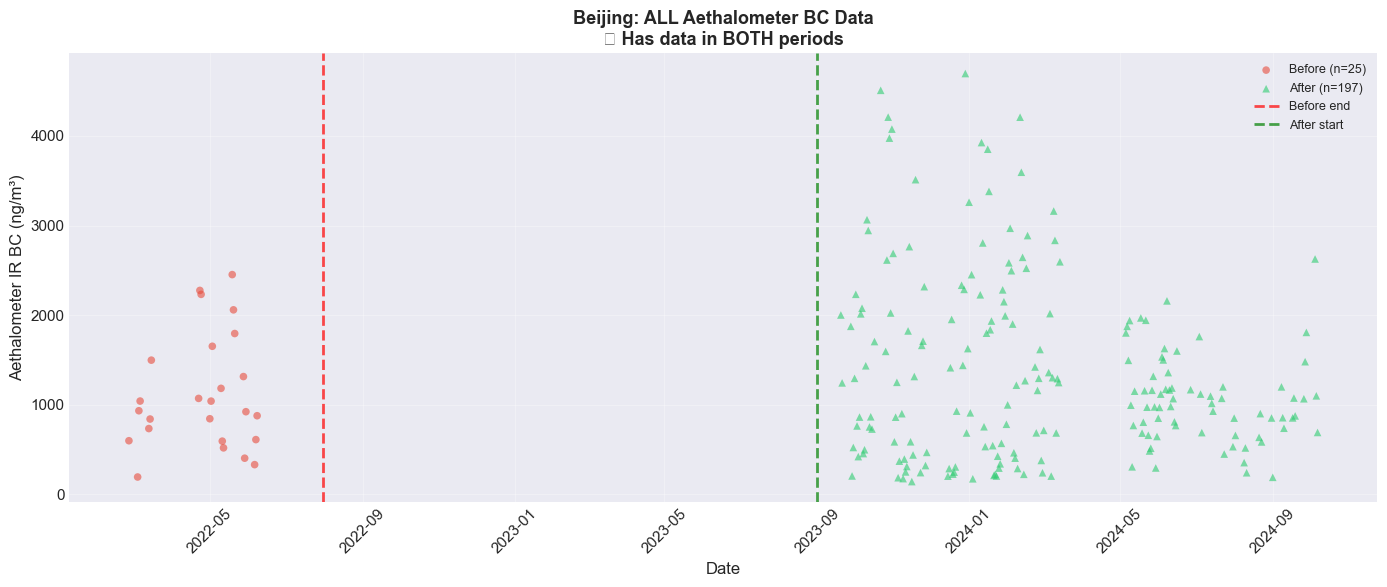


Beijing - All Aethalometer Data:
  Total records with IR BC: 222
  Date range: 2022-02-25 to 2024-10-07
    Before: 25 days
       Gap: NO DATA
     After: 197 days
  → ✓ Suitable for before/after comparison


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/2272357178.py:76: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


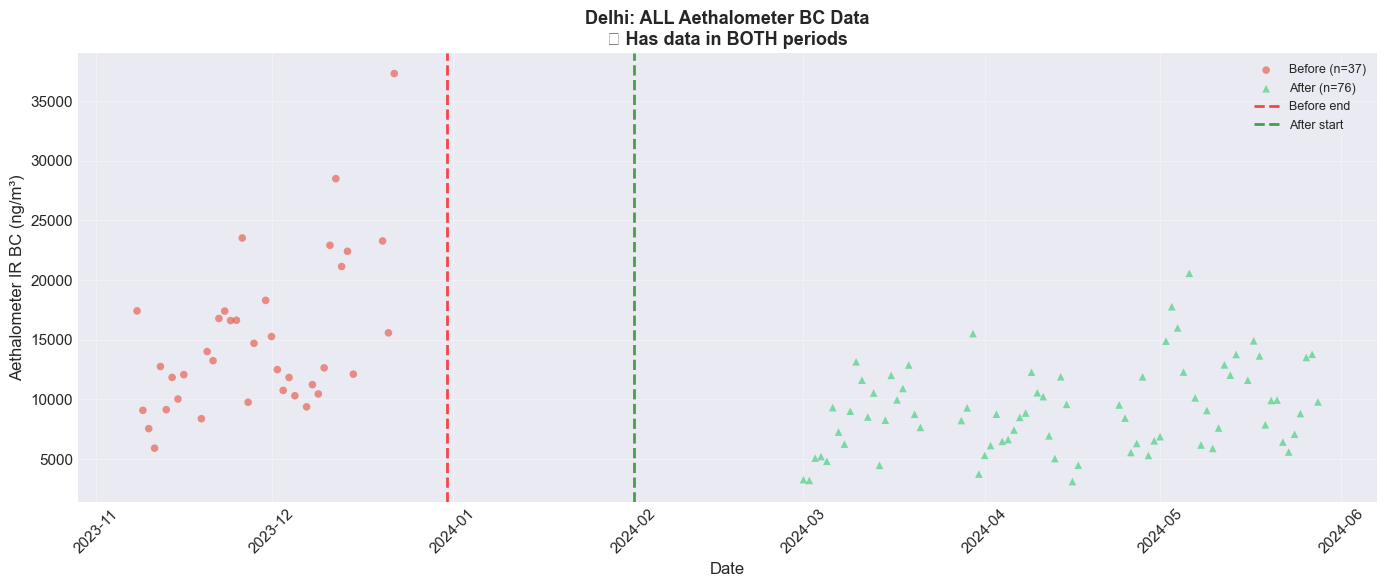


Delhi - All Aethalometer Data:
  Total records with IR BC: 113
  Date range: 2023-11-08 to 2024-05-28
    Before: 37 days
       Gap: NO DATA
     After: 76 days
  → ✓ Suitable for before/after comparison


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/2272357178.py:76: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


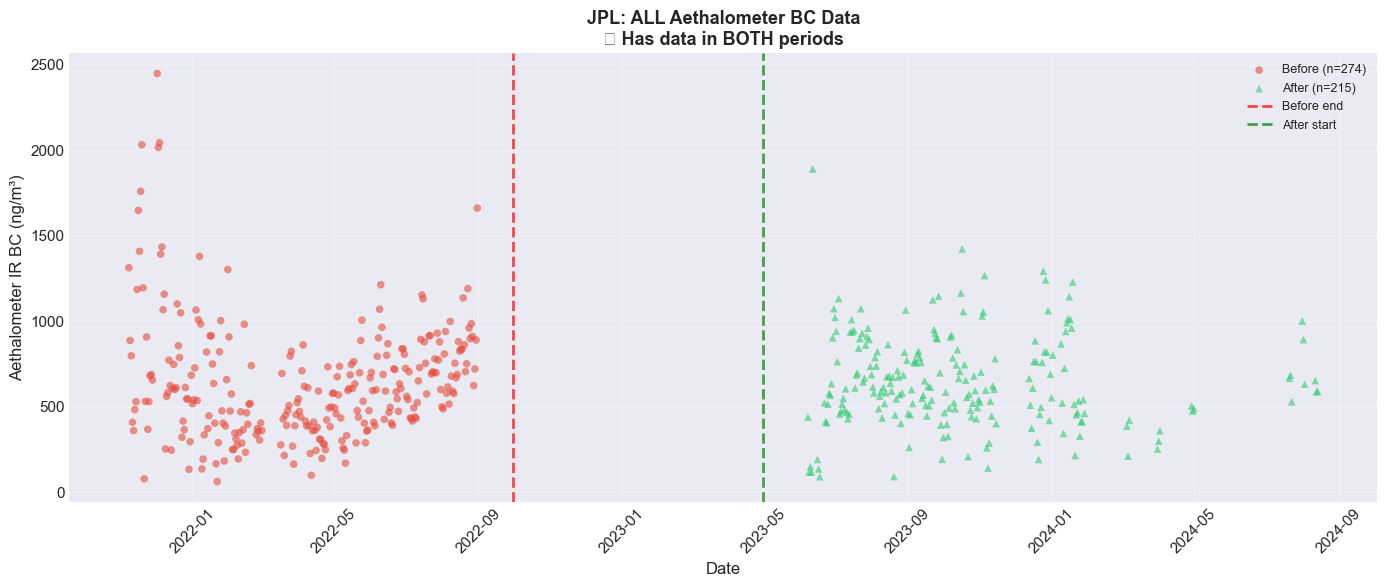


JPL - All Aethalometer Data:
  Total records with IR BC: 489
  Date range: 2021-11-08 to 2024-08-14
    Before: 274 days
       Gap: NO DATA
     After: 215 days
  → ✓ Suitable for before/after comparison


In [48]:
# Visualize ALL aethalometer data (not just filter-matched) by flow period
print("="*80)
print("ALL AETHALOMETER DATA BY FLOW PERIOD")
print("="*80)
print("\nShowing all aethalometer BC data (not limited to filter-matched dates)\n")

for site_name in ['Beijing', 'Delhi', 'JPL']:
    if site_name not in aethalometer_data:
        continue
    
    df_aeth = aethalometer_data[site_name].copy()
    dates_config = FLOW_FIX_DATES[site_name]
    
    # Add flow period classification to all aethalometer data
    df_aeth['flow_period'] = df_aeth['day_9am'].apply(lambda d: classify_flow_period(d, site_name))
    
    # Get BC data
    if 'IR BCc' not in df_aeth.columns:
        print(f"{site_name}: No IR BCc column")
        continue
    
    df_valid = df_aeth[df_aeth['IR BCc'].notna()].copy()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot time series colored by period
    colors = {'before': '#E74C3C', 'gap': '#95A5A6', 'after': '#2ECC71', 'no_fix': '#3498DB'}
    markers = {'before': 'o', 'gap': 's', 'after': '^', 'no_fix': 'o'}
    
    has_before = False
    has_after = False
    
    for period in ['before', 'gap', 'after', 'no_fix']:
        period_data = df_valid[df_valid['flow_period'] == period]
        if len(period_data) > 0:
            if period == 'before':
                has_before = True
            if period == 'after':
                has_after = True
            
            ax.scatter(period_data['day_9am'], period_data['IR BCc'], 
                      color=colors[period], marker=markers[period], s=30, alpha=0.6,
                      label=f'{period.capitalize()} (n={len(period_data)})', edgecolors='none')
    
    # Add vertical lines for flow fix period boundaries
    if dates_config['before_end']:
        ax.axvline(pd.to_datetime(dates_config['before_end']), color='red', 
                   linestyle='--', linewidth=2, alpha=0.7, label='Before end')
    if dates_config['after_start']:
        ax.axvline(pd.to_datetime(dates_config['after_start']), color='green',
                   linestyle='--', linewidth=2, alpha=0.7, label='After start')
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Aethalometer IR BC (ng/m³)', fontsize=12)
    
    # Add status indicator to title
    if has_before and has_after:
        status = "✓ Has data in BOTH periods"
        title_color = 'black'
    elif has_before:
        status = "Only has BEFORE data"
        title_color = 'red'
    elif has_after:
        status = "Only has AFTER data"
        title_color = 'red'
    else:
        status = "No period data"
        title_color = 'gray'
    
    ax.set_title(f'{site_name}: ALL Aethalometer BC Data\n{status}',
                 fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{site_name} - All Aethalometer Data:")
    print(f"  Total records with IR BC: {len(df_valid)}")
    print(f"  Date range: {df_valid['day_9am'].min().date()} to {df_valid['day_9am'].max().date()}")
    for period in ['before', 'gap', 'after']:
        period_data = df_valid[df_valid['flow_period'] == period]
        if len(period_data) > 0:
            print(f"  {period.capitalize():>8}: {len(period_data)} days")
        else:
            print(f"  {period.capitalize():>8}: NO DATA")
    
    if has_before and has_after:
        print(f"  → ✓ Suitable for before/after comparison")
    else:
        print(f"  → ✗ Cannot do before/after comparison")

## 6. Before/After Analysis: FTIR EC vs Aethalometer

BEFORE/AFTER FLOW FIX: FTIR EC vs Aethalometer

NOTE: Only JPL is shown - Beijing/Delhi lack 'before' period data
Comparing thermal (FTIR EC) vs optical (Aethalometer) measurements


JPL: FTIR EC vs Aethalometer


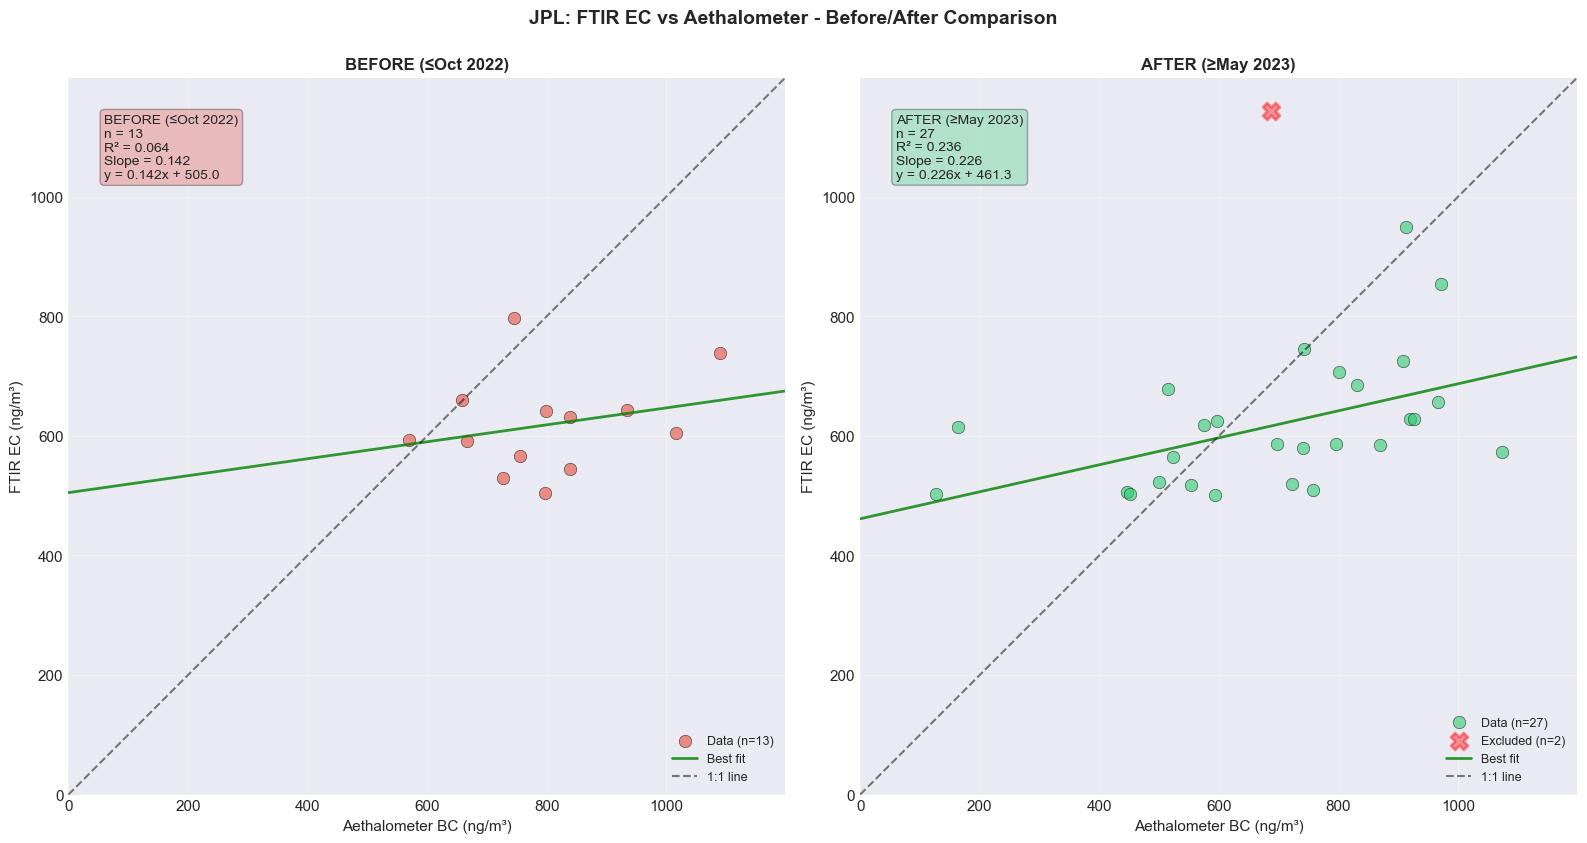


  Metric                Before        After       Change
  -------------------------------------------------------
  n                         13           27          +14
  R²                     0.064        0.236       +0.172
  Slope                  0.142        0.226       +0.084
  |Slope - 1|            0.858        0.774       -0.084

  ✓ R² IMPROVED by 0.172
  ✓ Slope moved closer to 1.0


In [49]:
# Before/After comparison: FTIR EC vs Aethalometer
# NOTE: Only JPL has data in both periods - Beijing and Delhi excluded
print("="*80)
print("BEFORE/AFTER FLOW FIX: FTIR EC vs Aethalometer")
print("="*80)
print("\nNOTE: Only JPL is shown - Beijing/Delhi lack 'before' period data")
print("Comparing thermal (FTIR EC) vs optical (Aethalometer) measurements\n")

ftir_results = {}

# Only analyze JPL (the only site with data in both periods)
for site_name in ['JPL']:
    if site_name not in ftir_aeth_data:
        print(f"\n{site_name}: No data")
        continue
    
    matched_df = ftir_aeth_data[site_name]
    config = SITES[site_name]
    
    # Verify we have data in both periods
    period_counts = matched_df['flow_period'].value_counts()
    if 'before' not in period_counts or 'after' not in period_counts:
        print(f"\n{site_name}: Missing data in one or both periods - skipping")
        continue
    
    print(f"\n{'='*60}")
    print(f"{site_name}: FTIR EC vs Aethalometer")
    print(f"{'='*60}")
    
    # Get clean data (exclude outliers)
    clean_df = matched_df[~matched_df['is_any_outlier']].copy()
    
    # Calculate overall axis limits
    all_x = clean_df['aeth_bc'].dropna().values
    all_y = clean_df['filter_ec'].dropna().values
    max_val = max(all_x.max(), all_y.max()) * 1.1 if len(all_x) > 0 and len(all_y) > 0 else 10000
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    site_results = {}
    
    for idx, (period, period_label, color) in enumerate([
        ('before', 'BEFORE (≤Oct 2022)', '#E74C3C'),
        ('after', 'AFTER (≥May 2023)', '#2ECC71')
    ]):
        ax = axes[idx]
        
        # Get data for this period
        period_data = clean_df[clean_df['flow_period'] == period]
        outlier_data = matched_df[(matched_df['flow_period'] == period) & matched_df['is_any_outlier']]
        
        if len(period_data) < 3:
            ax.text(0.5, 0.5, f'Insufficient data\n(n={len(period_data)})',
                    ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{period_label}', fontsize=12, fontweight='bold')
            site_results[period] = None
            continue
        
        x_data = period_data['aeth_bc'].values
        y_data = period_data['filter_ec'].values
        
        # Plot clean data
        ax.scatter(x_data, y_data, color=color, alpha=0.6, s=80,
                   edgecolors='black', linewidth=0.5, label=f'Data (n={len(x_data)})')
        
        # Plot outliers (faded)
        if len(outlier_data) > 0:
            ax.scatter(outlier_data['aeth_bc'], outlier_data['filter_ec'],
                       color='red', alpha=0.4, s=150, marker='X', linewidths=2,
                       label=f'Excluded (n={len(outlier_data)})')
        
        # Calculate regression
        stats = calculate_regression_stats(x_data, y_data)
        site_results[period] = stats
        
        if stats:
            # Regression line
            x_line = np.array([0, max_val])
            y_line = stats['slope'] * x_line + stats['intercept']
            ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit')
            
            # Stats text
            sign = '+' if stats['intercept'] >= 0 else '-'
            eq = f"y = {stats['slope']:.3f}x {sign} {abs(stats['intercept']):.1f}"
            stats_text = f"{period_label}\nn = {stats['n']}\nR² = {stats['r_squared']:.3f}\nSlope = {stats['slope']:.3f}\n{eq}"
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
        
        # Set axes
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        ax.set_xlabel('Aethalometer BC (ng/m³)', fontsize=11)
        ax.set_ylabel('FTIR EC (ng/m³)', fontsize=11)
        ax.set_title(f'{period_label}', fontsize=12, fontweight='bold')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{site_name}: FTIR EC vs Aethalometer - Before/After Comparison',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    ftir_results[site_name] = site_results
    
    # Print comparison
    if site_results.get('before') and site_results.get('after'):
        before = site_results['before']
        after = site_results['after']
        
        r2_change = after['r_squared'] - before['r_squared']
        slope_change = after['slope'] - before['slope']
        slope_improve = abs(before['slope'] - 1) - abs(after['slope'] - 1)
        
        print(f"\n  {'Metric':<15s} {'Before':>12s} {'After':>12s} {'Change':>12s}")
        print(f"  {'-'*55}")
        print(f"  {'n':<15s} {before['n']:>12d} {after['n']:>12d} {after['n']-before['n']:>+12d}")
        print(f"  {'R²':<15s} {before['r_squared']:>12.3f} {after['r_squared']:>12.3f} {r2_change:>+12.3f}")
        print(f"  {'Slope':<15s} {before['slope']:>12.3f} {after['slope']:>12.3f} {slope_change:>+12.3f}")
        print(f"  {'|Slope - 1|':<15s} {abs(before['slope']-1):>12.3f} {abs(after['slope']-1):>12.3f} {-slope_improve:>+12.3f}")
        
        if r2_change > 0.05:
            print(f"\n  ✓ R² IMPROVED by {r2_change:.3f}")
        elif r2_change < -0.05:
            print(f"\n  ✗ R² DECREASED by {abs(r2_change):.3f}")
        else:
            print(f"\n  ~ R² relatively unchanged ({r2_change:+.3f})")
        
        if slope_improve > 0.05:
            print(f"  ✓ Slope moved closer to 1.0")
        elif slope_improve < -0.05:
            print(f"  ✗ Slope moved further from 1.0")

## 7. Before/After Analysis: HIPS vs Aethalometer

BEFORE/AFTER FLOW FIX: HIPS vs Aethalometer

NOTE: Only JPL is shown - Beijing/Delhi lack 'before' period data
Comparing absorption (HIPS) vs absorption (Aethalometer) - like-to-like


JPL: HIPS vs Aethalometer


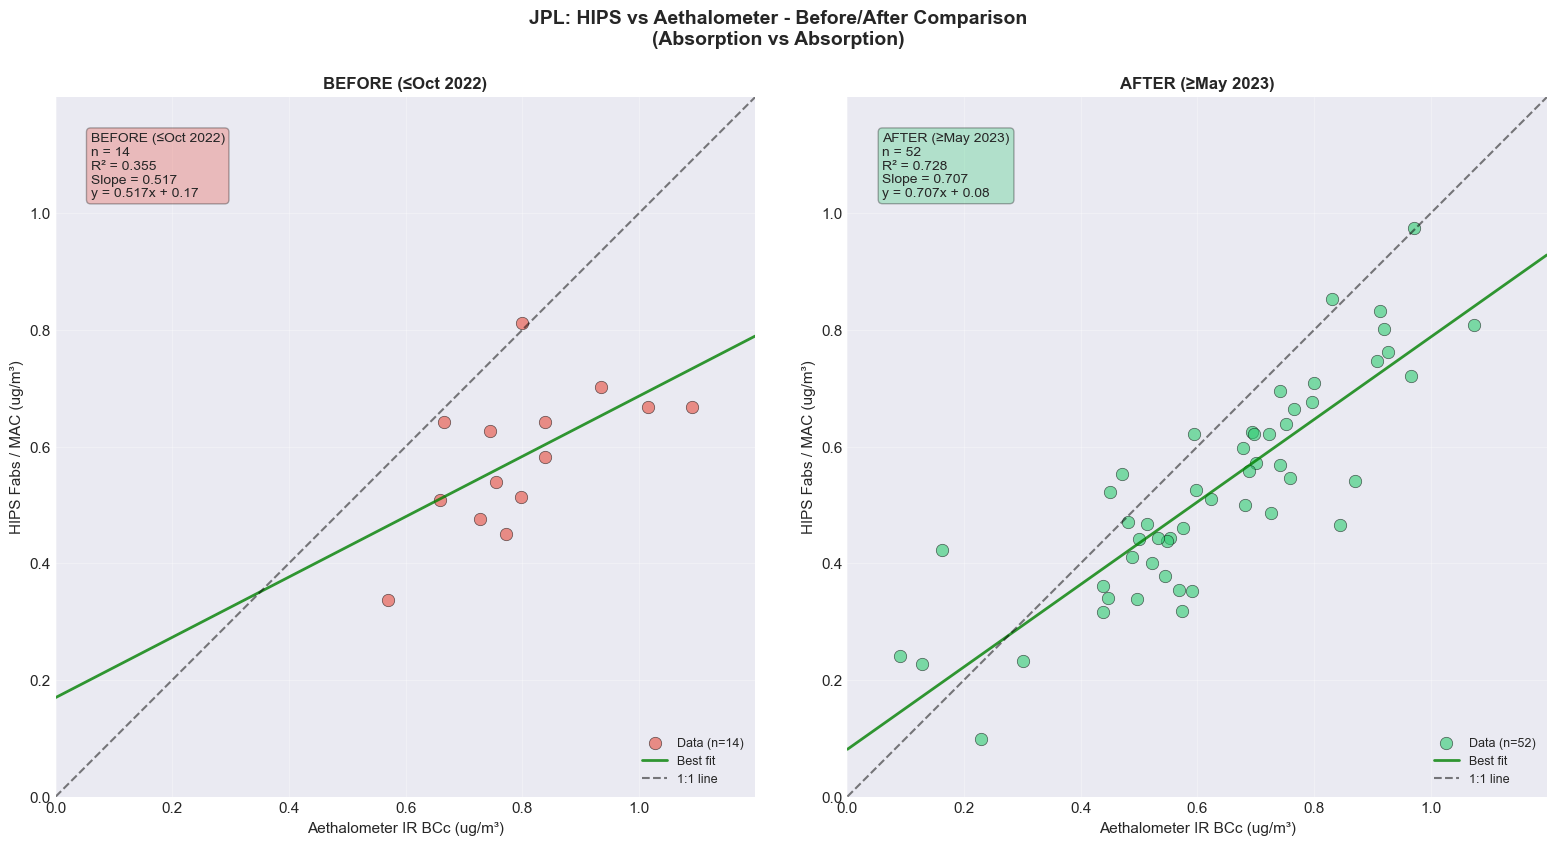


  Metric                Before        After       Change
  -------------------------------------------------------
  n                         14           52          +38
  R²                     0.355        0.728       +0.373
  Slope                  0.517        0.707       +0.190
  |Slope - 1|            0.483        0.293       -0.190

  ✓ R² IMPROVED by 0.373


In [50]:
# Before/After comparison: HIPS vs Aethalometer
# NOTE: Only JPL has data in both periods
print("="*80)
print("BEFORE/AFTER FLOW FIX: HIPS vs Aethalometer")
print("="*80)
print("\nNOTE: Only JPL is shown - Beijing/Delhi lack 'before' period data")
print("Comparing absorption (HIPS) vs absorption (Aethalometer) - like-to-like\n")

hips_results = {}

# Only analyze JPL
for site_name in ['JPL']:
    if site_name not in hips_aeth_data:
        print(f"\n{site_name}: No HIPS data")
        continue
    
    matched_df = hips_aeth_data[site_name]
    config = SITES[site_name]
    
    # Verify we have data in both periods
    period_counts = matched_df['flow_period'].value_counts()
    if 'before' not in period_counts or 'after' not in period_counts:
        print(f"\n{site_name}: Missing data in one or both periods - skipping")
        continue
    
    print(f"\n{'='*60}")
    print(f"{site_name}: HIPS vs Aethalometer")
    print(f"{'='*60}")
    
    # Get clean data (exclude outliers)
    clean_df = matched_df[~matched_df['is_any_outlier']].copy()
    
    # Filter for valid HIPS data
    clean_df = clean_df[clean_df['hips_fabs'].notna() & clean_df['ir_bcc'].notna()]
    
    if len(clean_df) < 3:
        print(f"  Insufficient data after filtering")
        continue
    
    # Calculate overall axis limits
    all_x = clean_df['ir_bcc'].dropna().values  # Already in ug/m3
    all_y = clean_df['hips_fabs'].dropna().values  # Already in ug/m3
    max_val = max(all_x.max(), all_y.max()) * 1.1 if len(all_x) > 0 and len(all_y) > 0 else 10
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    site_results = {}
    
    for idx, (period, period_label, color) in enumerate([
        ('before', 'BEFORE (≤Oct 2022)', '#E74C3C'),
        ('after', 'AFTER (≥May 2023)', '#2ECC71')
    ]):
        ax = axes[idx]
        
        # Get data for this period
        period_data = clean_df[clean_df['flow_period'] == period]
        
        if len(period_data) < 3:
            ax.text(0.5, 0.5, f'Insufficient data\n(n={len(period_data)})',
                    ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{period_label}', fontsize=12, fontweight='bold')
            site_results[period] = None
            continue
        
        x_data = period_data['ir_bcc'].values  # ug/m3
        y_data = period_data['hips_fabs'].values  # ug/m3
        
        # Plot data
        ax.scatter(x_data, y_data, color=color, alpha=0.6, s=80,
                   edgecolors='black', linewidth=0.5, label=f'Data (n={len(x_data)})')
        
        # Calculate regression
        stats = calculate_regression_stats(x_data, y_data)
        site_results[period] = stats
        
        if stats:
            # Regression line
            x_line = np.array([0, max_val])
            y_line = stats['slope'] * x_line + stats['intercept']
            ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit')
            
            # Stats text
            sign = '+' if stats['intercept'] >= 0 else '-'
            eq = f"y = {stats['slope']:.3f}x {sign} {abs(stats['intercept']):.2f}"
            stats_text = f"{period_label}\nn = {stats['n']}\nR² = {stats['r_squared']:.3f}\nSlope = {stats['slope']:.3f}\n{eq}"
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
        
        # Set axes
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        ax.set_xlabel('Aethalometer IR BCc (ug/m³)', fontsize=11)
        ax.set_ylabel('HIPS Fabs / MAC (ug/m³)', fontsize=11)
        ax.set_title(f'{period_label}', fontsize=12, fontweight='bold')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{site_name}: HIPS vs Aethalometer - Before/After Comparison\n(Absorption vs Absorption)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    hips_results[site_name] = site_results
    
    # Print comparison
    if site_results.get('before') and site_results.get('after'):
        before = site_results['before']
        after = site_results['after']
        
        r2_change = after['r_squared'] - before['r_squared']
        slope_change = after['slope'] - before['slope']
        slope_improve = abs(before['slope'] - 1) - abs(after['slope'] - 1)
        
        print(f"\n  {'Metric':<15s} {'Before':>12s} {'After':>12s} {'Change':>12s}")
        print(f"  {'-'*55}")
        print(f"  {'n':<15s} {before['n']:>12d} {after['n']:>12d} {after['n']-before['n']:>+12d}")
        print(f"  {'R²':<15s} {before['r_squared']:>12.3f} {after['r_squared']:>12.3f} {r2_change:>+12.3f}")
        print(f"  {'Slope':<15s} {before['slope']:>12.3f} {after['slope']:>12.3f} {slope_change:>+12.3f}")
        print(f"  {'|Slope - 1|':<15s} {abs(before['slope']-1):>12.3f} {abs(after['slope']-1):>12.3f} {-slope_improve:>+12.3f}")
        
        if r2_change > 0.05:
            print(f"\n  ✓ R² IMPROVED by {r2_change:.3f}")
        elif r2_change < -0.05:
            print(f"\n  ✗ R² DECREASED by {abs(r2_change):.3f}")
        else:
            print(f"\n  ~ R² relatively unchanged ({r2_change:+.3f})")

## 8. Summary Comparison Plot

SUMMARY: Before/After Comparison - JPL Only

NOTE: Beijing and Delhi excluded - no filter data in 'before' period



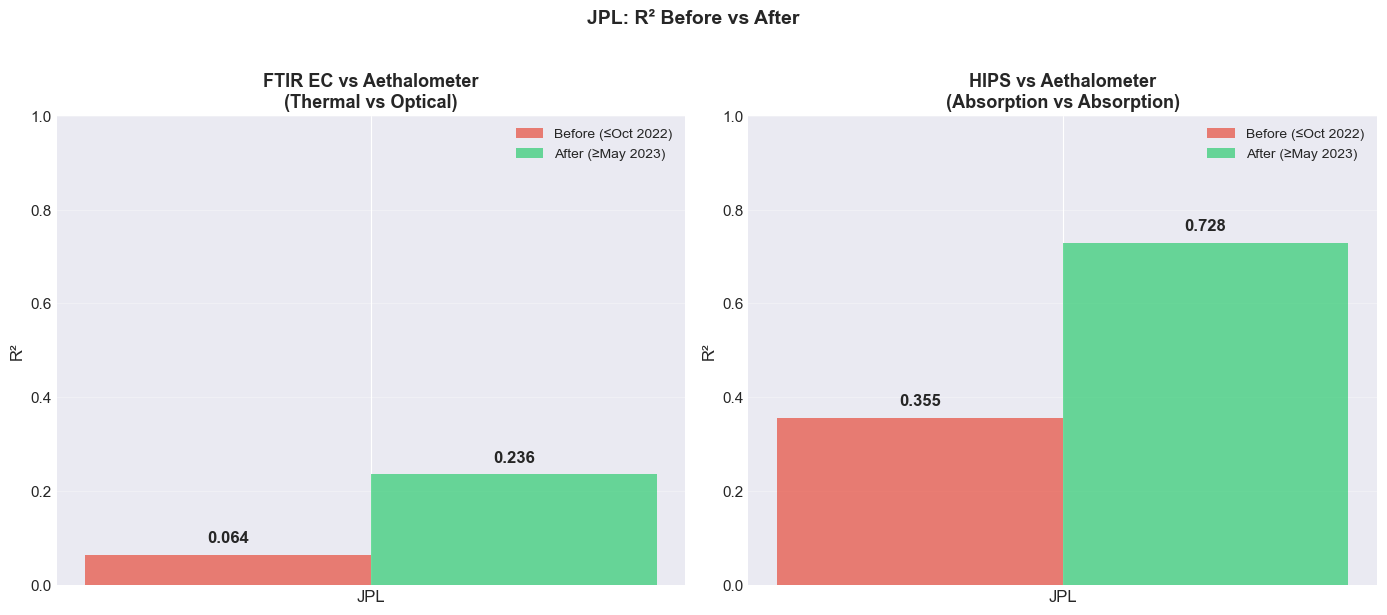

In [51]:
# Summary bar chart - JPL only (the only site with data in both periods)
print("="*80)
print("SUMMARY: Before/After Comparison - JPL Only")
print("="*80)
print("\nNOTE: Beijing and Delhi excluded - no filter data in 'before' period\n")

# Only JPL has both before and after data
sites = ['JPL']
x = np.arange(len(sites))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: R² comparison
ax1 = axes[0]

ftir_before_r2 = [ftir_results.get(s, {}).get('before', {}).get('r_squared', 0) if ftir_results.get(s, {}).get('before') else 0 for s in sites]
ftir_after_r2 = [ftir_results.get(s, {}).get('after', {}).get('r_squared', 0) if ftir_results.get(s, {}).get('after') else 0 for s in sites]

bars1 = ax1.bar(x - width/2, ftir_before_r2, width, label='Before (≤Oct 2022)', color='#E74C3C', alpha=0.7)
bars2 = ax1.bar(x + width/2, ftir_after_r2, width, label='After (≥May 2023)', color='#2ECC71', alpha=0.7)

for bar, val in zip(bars1, ftir_before_r2):
    if val > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
for bar, val in zip(bars2, ftir_after_r2):
    if val > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('R²', fontsize=12)
ax1.set_title('FTIR EC vs Aethalometer\n(Thermal vs Optical)', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(sites, fontsize=12)
ax1.legend(fontsize=10)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: HIPS R² comparison
ax2 = axes[1]

hips_before_r2 = [hips_results.get(s, {}).get('before', {}).get('r_squared', 0) if hips_results.get(s, {}).get('before') else 0 for s in sites]
hips_after_r2 = [hips_results.get(s, {}).get('after', {}).get('r_squared', 0) if hips_results.get(s, {}).get('after') else 0 for s in sites]

bars3 = ax2.bar(x - width/2, hips_before_r2, width, label='Before (≤Oct 2022)', color='#E74C3C', alpha=0.7)
bars4 = ax2.bar(x + width/2, hips_after_r2, width, label='After (≥May 2023)', color='#2ECC71', alpha=0.7)

for bar, val in zip(bars3, hips_before_r2):
    if val > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
for bar, val in zip(bars4, hips_after_r2):
    if val > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_ylabel('R²', fontsize=12)
ax2.set_title('HIPS vs Aethalometer\n(Absorption vs Absorption)', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(sites, fontsize=12)
ax2.legend(fontsize=10)
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3, axis='y')

plt.suptitle('JPL: R² Before vs After', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

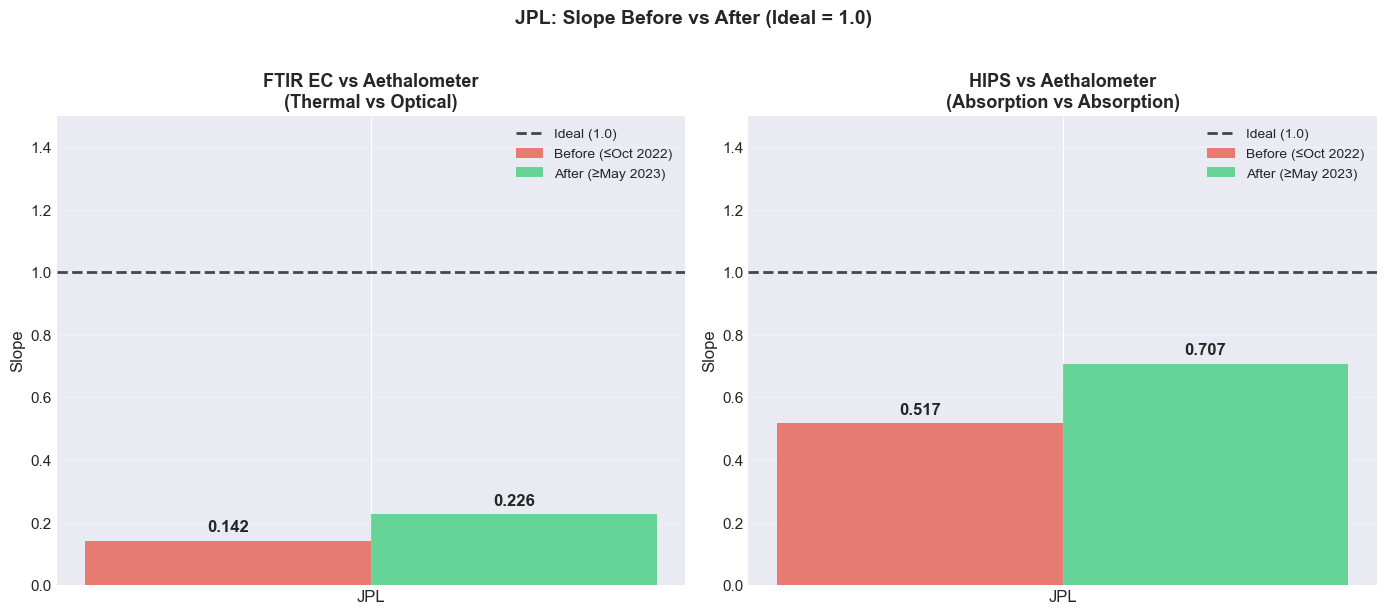

In [52]:
# Slope comparison plot - JPL only
sites = ['JPL']
x = np.arange(len(sites))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: FTIR EC slopes
ax1 = axes[0]

ftir_before_slope = [ftir_results.get(s, {}).get('before', {}).get('slope', 0) if ftir_results.get(s, {}).get('before') else 0 for s in sites]
ftir_after_slope = [ftir_results.get(s, {}).get('after', {}).get('slope', 0) if ftir_results.get(s, {}).get('after') else 0 for s in sites]

bars1 = ax1.bar(x - width/2, ftir_before_slope, width, label='Before (≤Oct 2022)', color='#E74C3C', alpha=0.7)
bars2 = ax1.bar(x + width/2, ftir_after_slope, width, label='After (≥May 2023)', color='#2ECC71', alpha=0.7)

ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Ideal (1.0)')

for bar, val in zip(bars1, ftir_before_slope):
    if val > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
for bar, val in zip(bars2, ftir_after_slope):
    if val > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Slope', fontsize=12)
ax1.set_title('FTIR EC vs Aethalometer\n(Thermal vs Optical)', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(sites, fontsize=12)
ax1.legend(fontsize=10)
ax1.set_ylim(0, 1.5)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: HIPS slopes
ax2 = axes[1]

hips_before_slope = [hips_results.get(s, {}).get('before', {}).get('slope', 0) if hips_results.get(s, {}).get('before') else 0 for s in sites]
hips_after_slope = [hips_results.get(s, {}).get('after', {}).get('slope', 0) if hips_results.get(s, {}).get('after') else 0 for s in sites]

bars3 = ax2.bar(x - width/2, hips_before_slope, width, label='Before (≤Oct 2022)', color='#E74C3C', alpha=0.7)
bars4 = ax2.bar(x + width/2, hips_after_slope, width, label='After (≥May 2023)', color='#2ECC71', alpha=0.7)

ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Ideal (1.0)')

for bar, val in zip(bars3, hips_before_slope):
    if val > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
for bar, val in zip(bars4, hips_after_slope):
    if val > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_ylabel('Slope', fontsize=12)
ax2.set_title('HIPS vs Aethalometer\n(Absorption vs Absorption)', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(sites, fontsize=12)
ax2.legend(fontsize=10)
ax2.set_ylim(0, 1.5)
ax2.grid(True, alpha=0.3, axis='y')

plt.suptitle('JPL: Slope Before vs After (Ideal = 1.0)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Comprehensive Summary Table

In [53]:
# Comprehensive summary table - JPL only
print("="*100)
print("SUMMARY: JPL Before/After Comparison")
print("="*100)
print("\nNOTE: Only JPL has filter data in both periods")
print("      Beijing and Delhi only have data from AFTER flow degradation started\n")

print("-"*80)
print("JPL: FTIR EC vs Aethalometer (Thermal vs Optical)")
print("-"*80)
results = ftir_results.get('JPL', {})
before = results.get('before')
after = results.get('after')

if before and after:
    r2_change = after['r_squared'] - before['r_squared']
    slope_improve = abs(before['slope'] - 1) - abs(after['slope'] - 1)
    
    print(f"  {'Metric':<15s} {'Before':>12s} {'After':>12s} {'Change':>12s}")
    print(f"  {'-'*55}")
    print(f"  {'n':<15s} {before['n']:>12d} {after['n']:>12d} {after['n']-before['n']:>+12d}")
    print(f"  {'R²':<15s} {before['r_squared']:>12.3f} {after['r_squared']:>12.3f} {r2_change:>+12.3f}")
    print(f"  {'Slope':<15s} {before['slope']:>12.3f} {after['slope']:>12.3f} {after['slope']-before['slope']:>+12.3f}")
    print(f"  {'|Slope - 1|':<15s} {abs(before['slope']-1):>12.3f} {abs(after['slope']-1):>12.3f} {-slope_improve:>+12.3f}")
else:
    print("  Insufficient data")

print("\n" + "-"*80)
print("JPL: HIPS vs Aethalometer (Absorption vs Absorption)")
print("-"*80)
results = hips_results.get('JPL', {})
before = results.get('before')
after = results.get('after')

if before and after:
    r2_change = after['r_squared'] - before['r_squared']
    slope_improve = abs(before['slope'] - 1) - abs(after['slope'] - 1)
    
    print(f"  {'Metric':<15s} {'Before':>12s} {'After':>12s} {'Change':>12s}")
    print(f"  {'-'*55}")
    print(f"  {'n':<15s} {before['n']:>12d} {after['n']:>12d} {after['n']-before['n']:>+12d}")
    print(f"  {'R²':<15s} {before['r_squared']:>12.3f} {after['r_squared']:>12.3f} {r2_change:>+12.3f}")
    print(f"  {'Slope':<15s} {before['slope']:>12.3f} {after['slope']:>12.3f} {after['slope']-before['slope']:>+12.3f}")
    print(f"  {'|Slope - 1|':<15s} {abs(before['slope']-1):>12.3f} {abs(after['slope']-1):>12.3f} {-slope_improve:>+12.3f}")
else:
    print("  Insufficient data")

SUMMARY: JPL Before/After Comparison

NOTE: Only JPL has filter data in both periods
      Beijing and Delhi only have data from AFTER flow degradation started

--------------------------------------------------------------------------------
JPL: FTIR EC vs Aethalometer (Thermal vs Optical)
--------------------------------------------------------------------------------
  Metric                Before        After       Change
  -------------------------------------------------------
  n                         13           27          +14
  R²                     0.064        0.236       +0.172
  Slope                  0.142        0.226       +0.084
  |Slope - 1|            0.858        0.774       -0.084

--------------------------------------------------------------------------------
JPL: HIPS vs Aethalometer (Absorption vs Absorption)
--------------------------------------------------------------------------------
  Metric                Before        After       Change
  ---------

## 10. Key Findings & Conclusions

In [54]:
# Key findings
print("="*100)
print("KEY FINDINGS & CONCLUSIONS")
print("="*100)

print("""
DATA AVAILABILITY:
==================
  - JPL:     ✓ Has filter data in both 'before' (≤Oct 2022) and 'after' (≥May 2023) periods
  - Beijing: ✗ Only has data from Sep 2023+ (degraded flow period, ratio ~1.8-2.2)
  - Delhi:   ✗ Only has data from Feb 2024+ (degraded flow period, ratio ~2.5-3.2)

IMPORTANT NOTE ON FLOW RATIO:
=============================
  The flow ratio graphs show that:
  - Beijing flow ratio INCREASED over time (1.2 → 1.8-2.2) - flow degraded, not fixed
  - Delhi flow ratio INCREASED over time (1.6 → 3.2) - flow degraded, not fixed
  - This means there was no "flow fix" at these sites during the data period
  - Filter sampling started AFTER flow degradation began

JPL BEFORE/AFTER ANALYSIS:
==========================
  JPL is the only site suitable for before/after comparison.
""")

# JPL results
print("JPL Results:")
ftir = ftir_results.get('JPL', {})
if ftir.get('before') and ftir.get('after'):
    r2_change = ftir['after']['r_squared'] - ftir['before']['r_squared']
    print(f"  FTIR EC: R² {ftir['before']['r_squared']:.3f} → {ftir['after']['r_squared']:.3f} ({r2_change:+.3f})")
    if r2_change > 0.05:
        print(f"    ✓ IMPROVED")
    elif r2_change < -0.05:
        print(f"    ✗ WORSENED")
    else:
        print(f"    ~ No significant change")
else:
    print("  FTIR EC: Insufficient data")

hips = hips_results.get('JPL', {})
if hips.get('before') and hips.get('after'):
    r2_change = hips['after']['r_squared'] - hips['before']['r_squared']
    print(f"  HIPS:    R² {hips['before']['r_squared']:.3f} → {hips['after']['r_squared']:.3f} ({r2_change:+.3f})")
    if r2_change > 0.05:
        print(f"    ✓ IMPROVED")
    elif r2_change < -0.05:
        print(f"    ✗ WORSENED")
    else:
        print(f"    ~ No significant change")
else:
    print("  HIPS: Insufficient data")

print("""
CONCLUSIONS:
============
1. Before/after flow fix analysis is only possible for JPL
2. Beijing and Delhi lack "before" period data - filter sampling started too late
3. Flow ratio data shows Beijing and Delhi flows DEGRADED over time, not improved
4. Future analysis should consider comparing periods within the available data
   based on actual flow ratio quality, not assumed fix dates
""")

KEY FINDINGS & CONCLUSIONS

DATA AVAILABILITY:
  - JPL:     ✓ Has filter data in both 'before' (≤Oct 2022) and 'after' (≥May 2023) periods
  - Beijing: ✗ Only has data from Sep 2023+ (degraded flow period, ratio ~1.8-2.2)
  - Delhi:   ✗ Only has data from Feb 2024+ (degraded flow period, ratio ~2.5-3.2)

IMPORTANT NOTE ON FLOW RATIO:
  The flow ratio graphs show that:
  - Beijing flow ratio INCREASED over time (1.2 → 1.8-2.2) - flow degraded, not fixed
  - Delhi flow ratio INCREASED over time (1.6 → 3.2) - flow degraded, not fixed
  - This means there was no "flow fix" at these sites during the data period
  - Filter sampling started AFTER flow degradation began

JPL BEFORE/AFTER ANALYSIS:
  JPL is the only site suitable for before/after comparison.

JPL Results:
  FTIR EC: R² 0.064 → 0.236 (+0.172)
    ✓ IMPROVED
  HIPS:    R² 0.355 → 0.728 (+0.373)
    ✓ IMPROVED

CONCLUSIONS:
1. Before/after flow fix analysis is only possible for JPL
2. Beijing and Delhi lack "before" period data - 

---

## Notes

### Data Availability Summary

| Site | Filter Data Period | Flow Ratio Status | Before/After Possible |
|------|-------------------|-------------------|----------------------|
| **JPL** | Both periods | Good throughout | **Yes** |
| **Beijing** | Sep 2023+ only | Degraded (~1.8-2.2) | No |
| **Delhi** | Feb 2024+ only | Degraded (~2.5-3.2) | No |

### Key Observations from Flow Ratio Graphs

1. **Delhi**: Flow1/Flow2 ratio started ~1.6 in Nov 2023 and **increased** to ~3.2 by mid-2024
   - Flow is getting WORSE over time, not better
   - No evidence of a flow fix in the available data

2. **Beijing**: Flow1/Flow2 ratio was ~1.2 in early 2022, then jumped to ~1.8-2.2 after Sep 2023
   - Flow degraded after the data gap
   - Filter sampling only started after degradation

3. **JPL**: Has consistent data in both before and after periods
   - Only site suitable for before/after comparison

### Why Beijing and Delhi Show "Insufficient Data"

The original flow fix dates defined:
- Beijing: Before Aug 2022, After Sep 2023
- Delhi: Before Jan 2024, After Feb 2024

But filter sampling at these sites only started AFTER the "before_end" dates, meaning all filter data falls into the "after" category with nothing to compare against.

### Future Considerations

For Beijing and Delhi, alternative analyses could include:
- Comparing periods of high vs low flow ratio within the available data
- Correlating measurement agreement with flow ratio quality
- Analyzing measurement uncertainty as a function of flow ratio

---

## 11. Wavelength Dependence Analysis: Before vs After

Compare BC measurements at different wavelengths between before and after periods. This helps understand:
- Whether wavelength relationships changed after the flow fix
- Source apportionment differences (biomass burning vs fossil fuel)
- Potential measurement artifacts related to flow issues

WAVELENGTH DEPENDENCE ANALYSIS: Before vs After

Beijing: Wavelength BC Analysis by Flow Period
Available wavelengths: ['UV', 'Blue', 'Green', 'Red', 'IR']


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/3137211921.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,
/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/3137211921.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


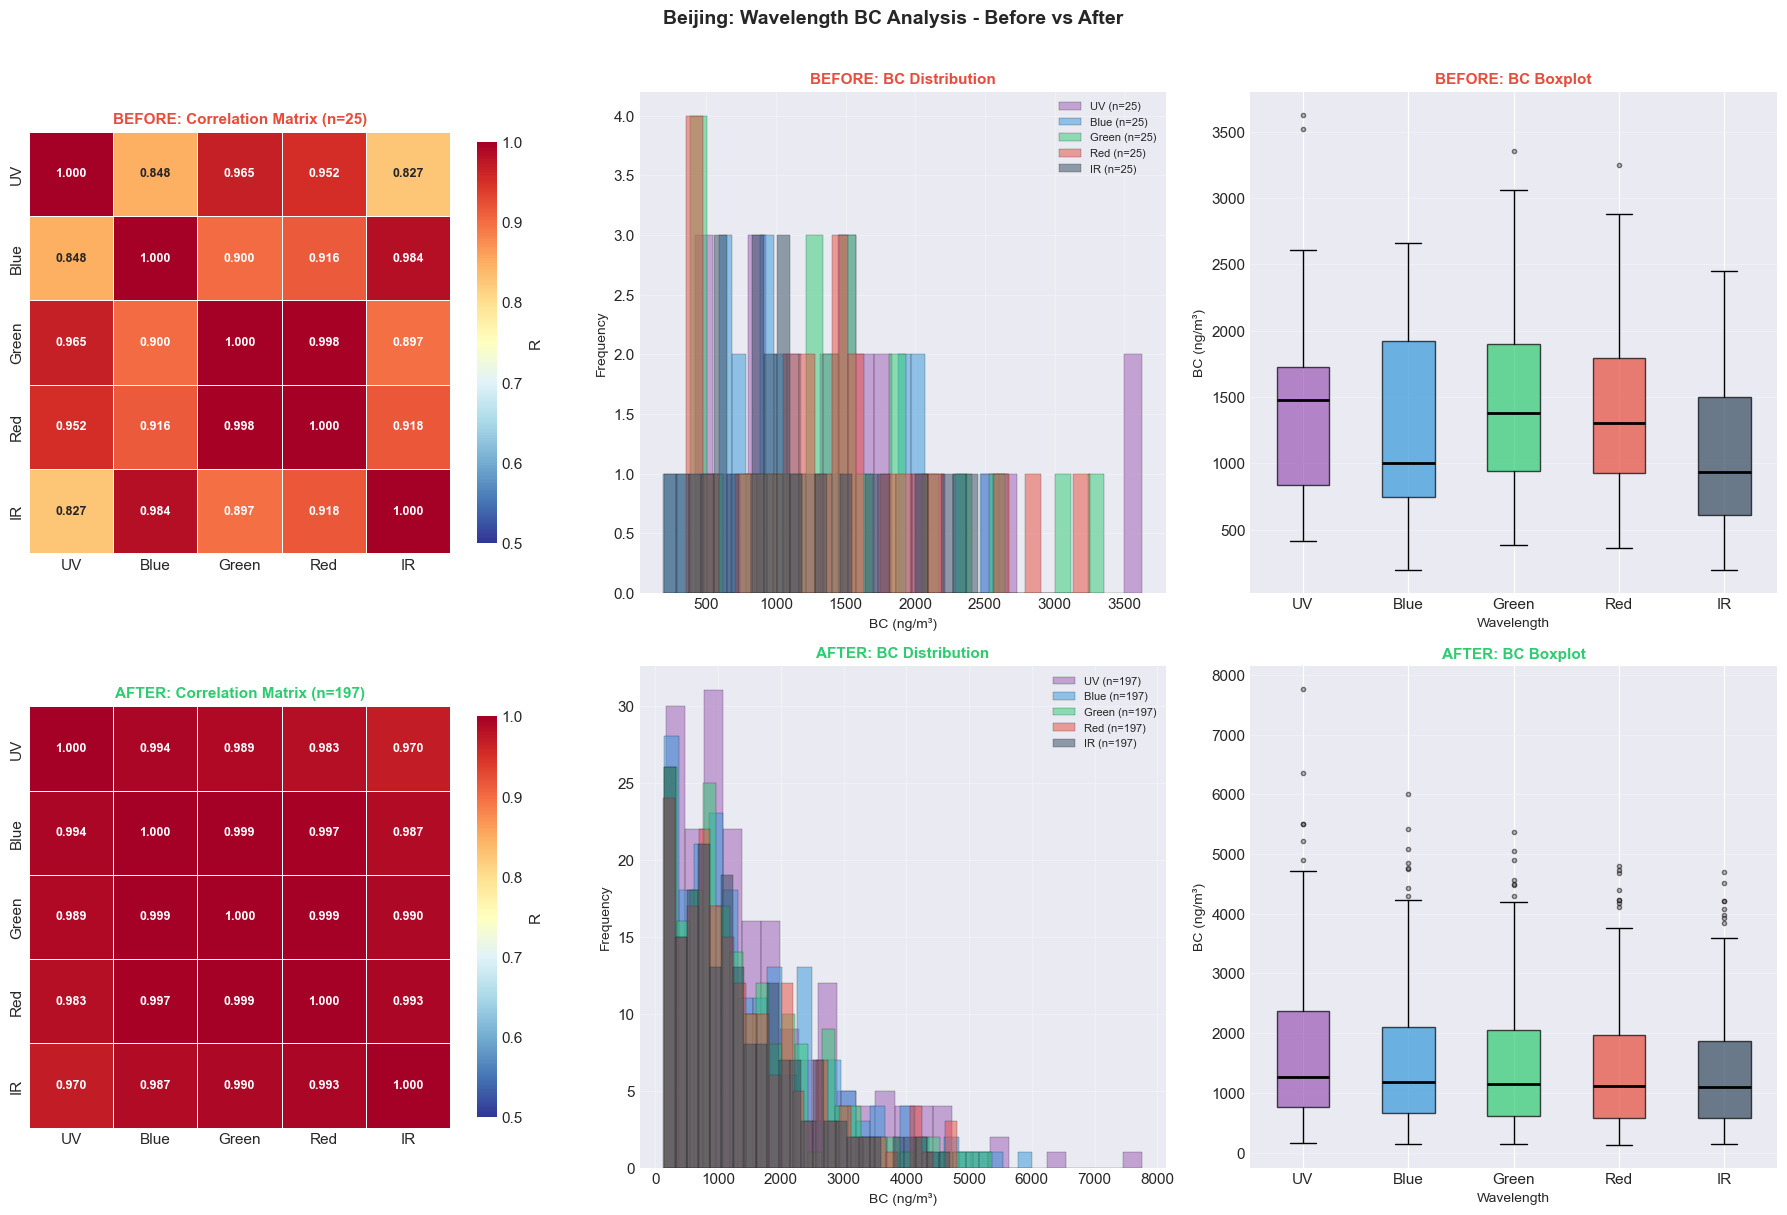


  BEFORE Period Summary:
  Wavelength          n       Mean     Median        Std
  -------------------------------------------------------
  UV                 25     1527.6     1475.8      867.0
  Blue               25     1217.6      999.7      698.3
  Green              25     1454.9     1378.3      797.0
  Red                25     1402.6     1307.2      769.2
  IR                 25     1120.8      933.2      638.0

  AFTER Period Summary:
  Wavelength          n       Mean     Median        Std
  -------------------------------------------------------
  UV                197     1706.9     1273.0     1347.4
  Blue              197     1547.0     1186.6     1191.7
  Green             197     1466.2     1149.0     1118.4
  Red               197     1395.1     1121.0     1054.9
  IR                197     1343.3     1099.6      997.2

Delhi: Wavelength BC Analysis by Flow Period
Available wavelengths: ['UV', 'Blue', 'Green', 'Red', 'IR']


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/3137211921.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,
/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/3137211921.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


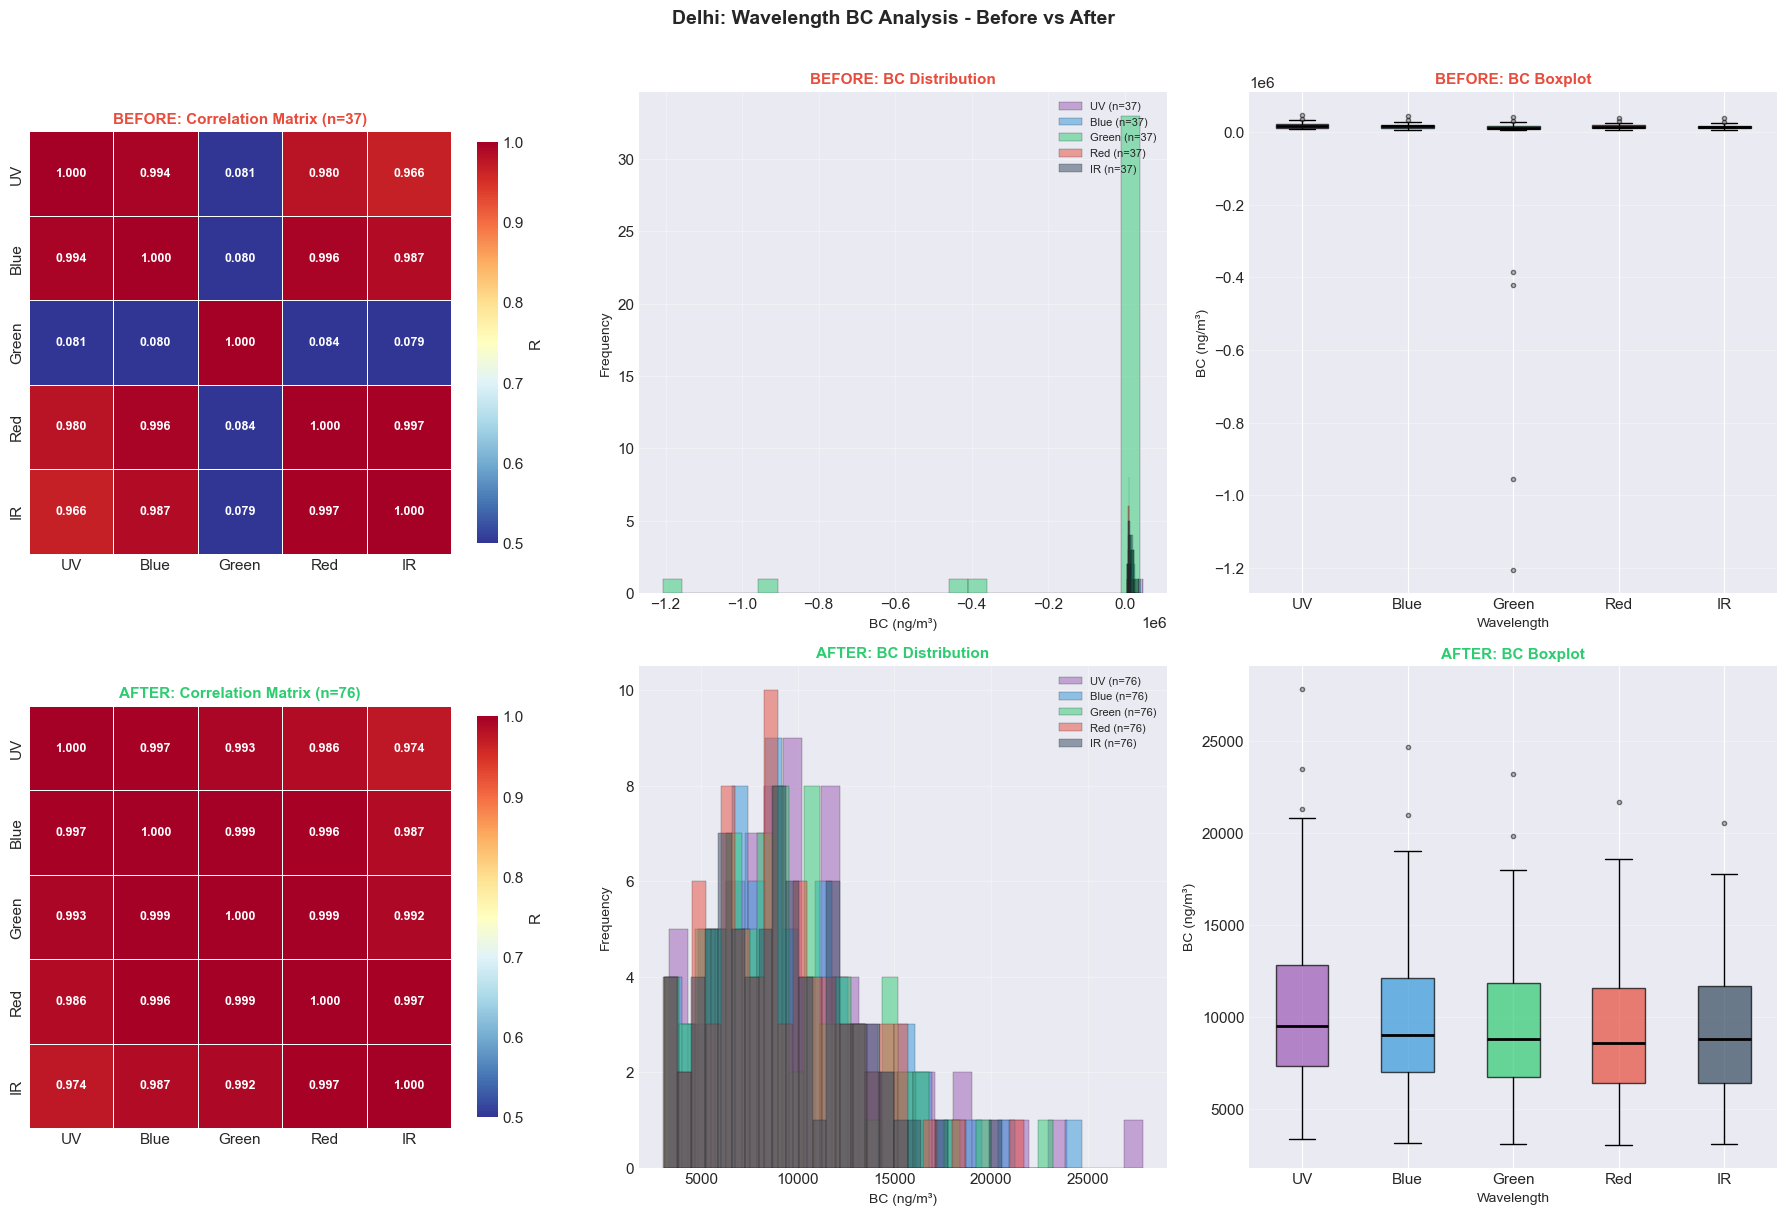


  BEFORE Period Summary:
  Wavelength          n       Mean     Median        Std
  -------------------------------------------------------
  UV                 37    18545.6    16750.8     8611.1
  Blue               37    16772.4    15099.0     7545.6
  Green              37   -67032.2    11384.0   265583.0
  Red                37    15315.6    13391.3     6689.2
  IR                 37    14936.8    12752.8     6401.7

  AFTER Period Summary:
  Wavelength          n       Mean     Median        Std
  -------------------------------------------------------
  UV                 76    10595.0     9525.2     4840.7
  Blue               76     9874.9     9019.1     4308.9
  Green              76     9542.7     8802.2     4060.4
  Red                76     9223.5     8599.0     3796.9
  IR                 76     9121.9     8782.4     3585.8

JPL: Wavelength BC Analysis by Flow Period
Available wavelengths: ['UV', 'Blue', 'Green', 'Red', 'IR']


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/3137211921.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,
/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/3137211921.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


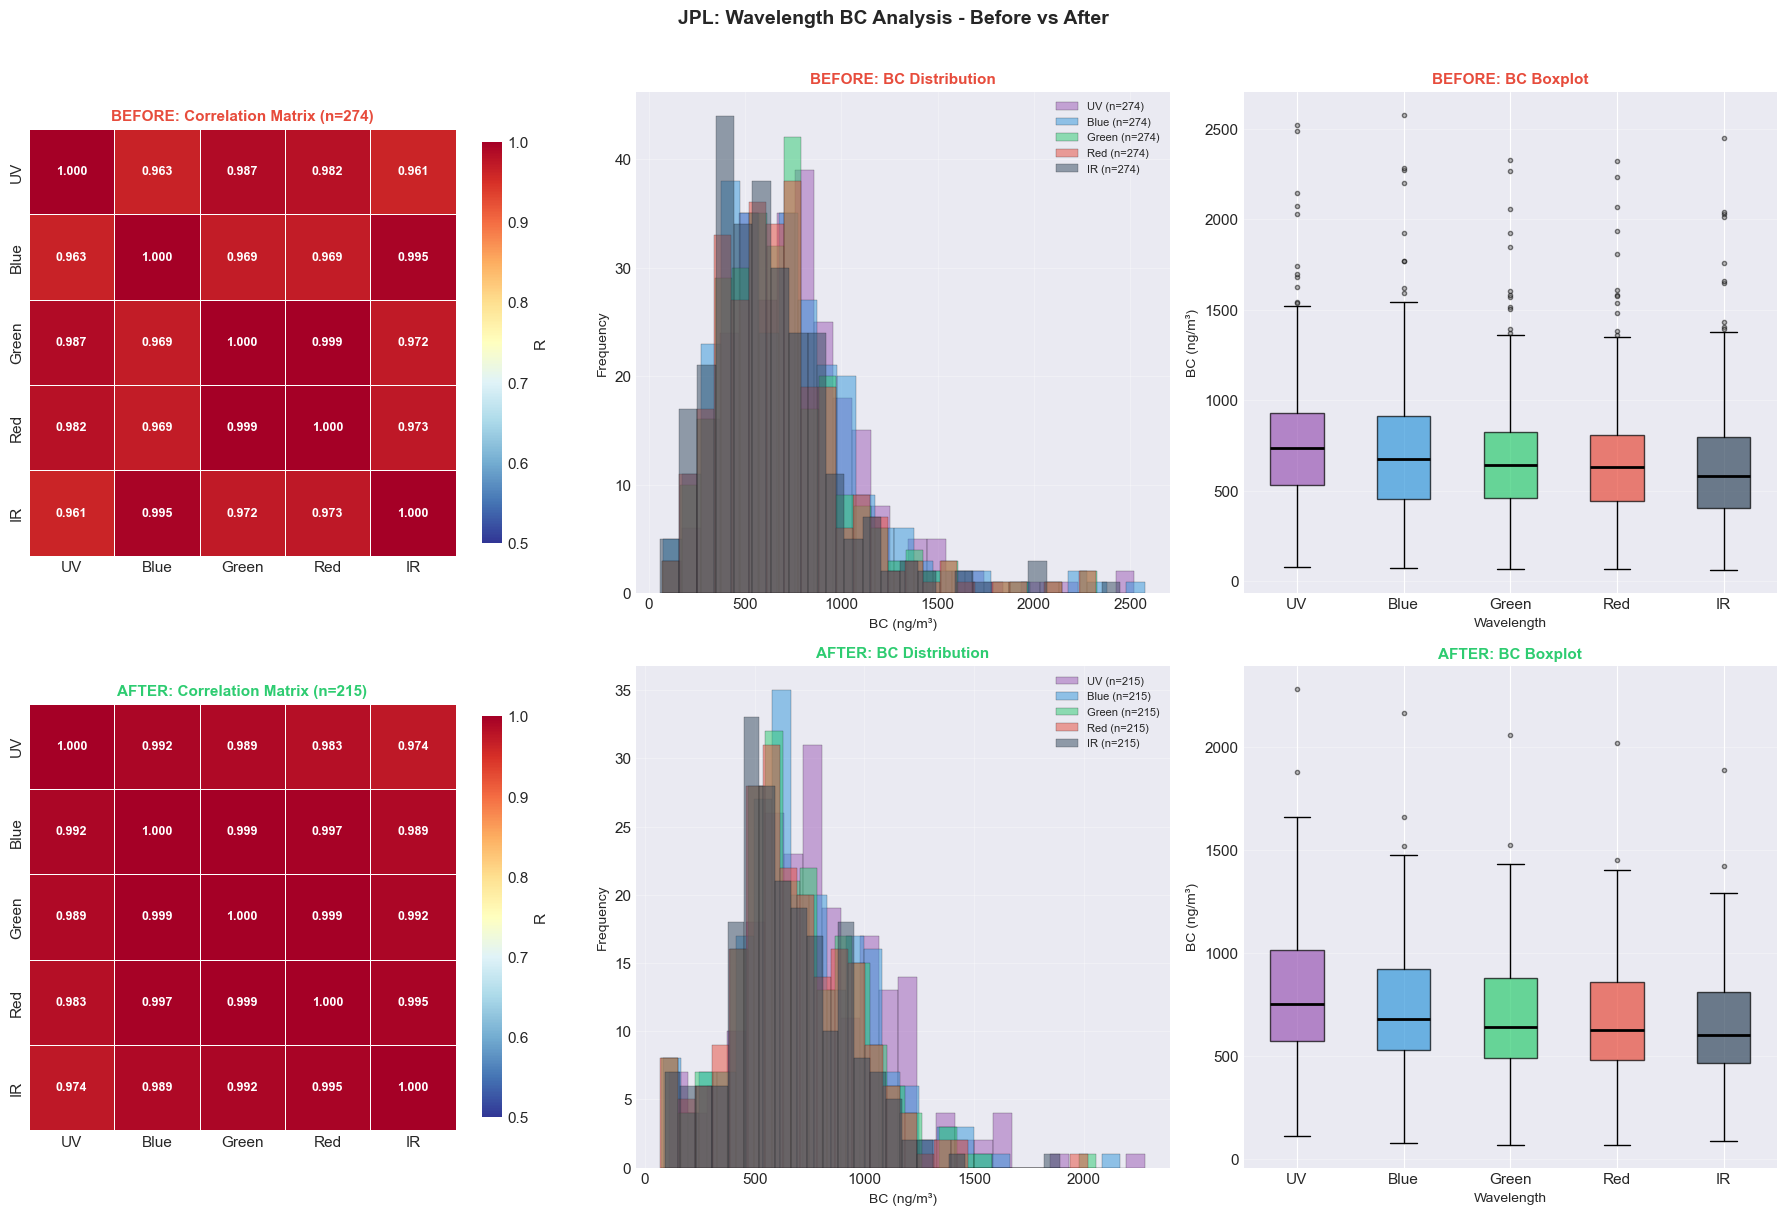


  BEFORE Period Summary:
  Wavelength          n       Mean     Median        Std
  -------------------------------------------------------
  UV                274      775.4      736.0      369.7
  Blue              274      724.7      677.0      381.5
  Green             274      695.0      643.3      345.6
  Red               274      681.8      631.3      344.8
  IR                274      637.7      583.4      345.4

  AFTER Period Summary:
  Wavelength          n       Mean     Median        Std
  -------------------------------------------------------
  UV                215      796.0      751.7      338.4
  Blue              215      727.7      679.8      312.9
  Green             215      686.1      642.9      295.4
  Red               215      669.7      627.7      288.6
  IR                215      645.1      603.7      270.2


In [55]:
# Wavelength Dependence Analysis: Before vs After
# For each site, compare wavelength BC relationships between periods

wavelengths = ['UV', 'Blue', 'Green', 'Red', 'IR']
wavelength_colors = {
    'UV': '#9B59B6',    # Purple
    'Blue': '#3498DB',  # Blue
    'Green': '#2ECC71', # Green
    'Red': '#E74C3C',   # Red
    'IR': '#34495E'     # Dark gray
}

print("="*80)
print("WAVELENGTH DEPENDENCE ANALYSIS: Before vs After")
print("="*80)

for site_name in ['Beijing', 'Delhi', 'JPL']:
    if site_name not in aethalometer_data:
        continue
    
    df_aeth = aethalometer_data[site_name].copy()
    dates_config = FLOW_FIX_DATES[site_name]
    
    # Add flow period classification
    df_aeth['flow_period'] = df_aeth['day_9am'].apply(lambda d: classify_flow_period(d, site_name))
    
    print(f"\n{'='*70}")
    print(f"{site_name}: Wavelength BC Analysis by Flow Period")
    print(f"{'='*70}")
    
    # Check available wavelengths
    available_wl = []
    for wl in wavelengths:
        col = f'{wl} BCc'
        if col in df_aeth.columns and df_aeth[col].notna().sum() > 0:
            available_wl.append(wl)
    
    print(f"Available wavelengths: {available_wl}")
    
    if len(available_wl) < 2:
        print("  Insufficient wavelength data")
        continue
    
    # Create figure with 2 rows (before/after) x 3 cols (correlation, histogram, boxplot)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    period_configs = [
        ('before', 'BEFORE', '#E74C3C'),
        ('after', 'AFTER', '#2ECC71')
    ]
    
    for row_idx, (period, period_label, period_color) in enumerate(period_configs):
        period_data = df_aeth[df_aeth['flow_period'] == period].copy()
        
        if len(period_data) < 5:
            for col_idx in range(3):
                axes[row_idx, col_idx].text(0.5, 0.5, f'{period_label}\nInsufficient data\n(n={len(period_data)})',
                                            ha='center', va='center', fontsize=14,
                                            transform=axes[row_idx, col_idx].transAxes)
                axes[row_idx, col_idx].set_title(f'{period_label}', fontsize=12, fontweight='bold', color=period_color)
            continue
        
        # Collect BC data for available wavelengths
        bc_data = {}
        for wl in available_wl:
            col = f'{wl} BCc'
            valid_data = period_data[col].dropna()
            if len(valid_data) > 0:
                bc_data[wl] = valid_data
        
        # Create DataFrame for correlation
        bc_df = pd.DataFrame({wl: period_data[f'{wl} BCc'] for wl in bc_data.keys()})
        bc_df_complete = bc_df.dropna()
        
        # ========== 1. Correlation Matrix Heatmap (using seaborn) ==========
        ax1 = axes[row_idx, 0]
        
        if len(bc_df_complete) >= 3:
            corr_matrix = bc_df_complete.corr()
            
            # Use seaborn heatmap to avoid white line artifacts
            sns.heatmap(corr_matrix, ax=ax1, annot=True, fmt='.3f', 
                       cmap='RdYlBu_r', vmin=0.5, vmax=1.0,
                       square=True, linewidths=0.5, linecolor='white',
                       cbar_kws={'shrink': 0.8, 'label': 'R'},
                       annot_kws={'size': 9, 'fontweight': 'bold'})
        
        ax1.set_title(f'{period_label}: Correlation Matrix (n={len(bc_df_complete)})',
                     fontsize=11, fontweight='bold', color=period_color)
        
        # ========== 2. BC Distribution Histogram ==========
        ax2 = axes[row_idx, 1]
        
        for wl in wavelengths:
            if wl in bc_data:
                data = bc_data[wl]
                ax2.hist(data, bins=25, alpha=0.5, color=wavelength_colors[wl],
                        label=f'{wl} (n={len(data)})', edgecolor='black', linewidth=0.3)
        
        ax2.set_xlabel('BC (ng/m³)', fontsize=10)
        ax2.set_ylabel('Frequency', fontsize=10)
        ax2.set_title(f'{period_label}: BC Distribution', fontsize=11, fontweight='bold', color=period_color)
        ax2.legend(loc='upper right', fontsize=8)
        ax2.grid(True, alpha=0.3)
        
        # ========== 3. BC Distribution Boxplot ==========
        ax3 = axes[row_idx, 2]
        
        boxplot_data = []
        boxplot_labels = []
        boxplot_colors_list = []
        
        for wl in wavelengths:
            if wl in bc_data:
                boxplot_data.append(bc_data[wl].values)
                boxplot_labels.append(wl)
                boxplot_colors_list.append(wavelength_colors[wl])
        
        if len(boxplot_data) > 0:
            bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,
                            medianprops=dict(color='black', linewidth=2),
                            flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.5))
            
            for patch, color in zip(bp['boxes'], boxplot_colors_list):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
        
        ax3.set_xlabel('Wavelength', fontsize=10)
        ax3.set_ylabel('BC (ng/m³)', fontsize=10)
        ax3.set_title(f'{period_label}: BC Boxplot', fontsize=11, fontweight='bold', color=period_color)
        ax3.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'{site_name}: Wavelength BC Analysis - Before vs After',
                fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for each period
    for period, period_label, _ in period_configs:
        period_data = df_aeth[df_aeth['flow_period'] == period]
        if len(period_data) >= 5:
            print(f"\n  {period_label} Period Summary:")
            print(f"  {'Wavelength':<12s} {'n':>8s} {'Mean':>10s} {'Median':>10s} {'Std':>10s}")
            print("  " + "-" * 55)
            for wl in wavelengths:
                col = f'{wl} BCc'
                if col in period_data.columns:
                    data = period_data[col].dropna()
                    if len(data) > 0:
                        print(f"  {wl:<12s} {len(data):>8d} {data.mean():>10.1f} {data.median():>10.1f} {data.std():>10.1f}")


UV/IR RATIO COMPARISON: Before vs After

Interpretation:
  - UV/IR > 1.0: Strong UV absorption → biomass burning
  - UV/IR ~ 1.0: Equal absorption → mixed sources
  - UV/IR < 1.0: Strong IR absorption → fossil fuel


Beijing: UV/IR Ratio by Flow Period


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/145970430.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


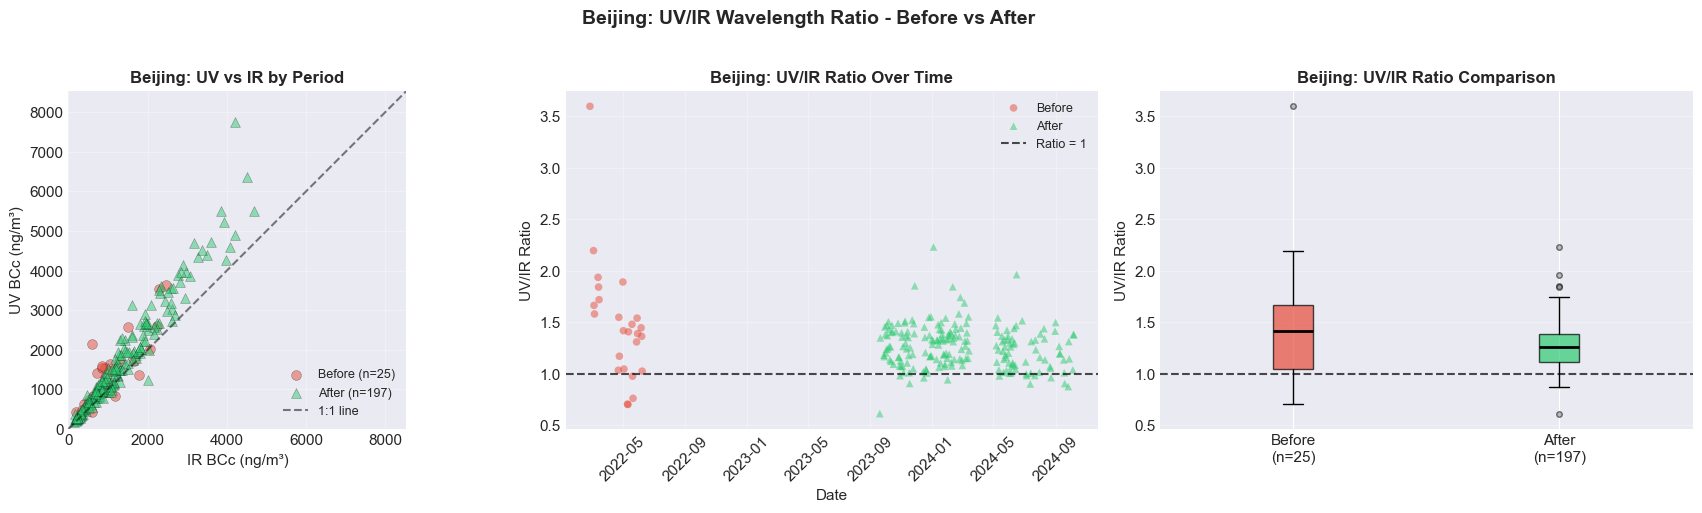


  Period            n   Mean UV/IR   Median UV/IR        Std
  ------------------------------------------------------------
  Before           25        1.470          1.418      0.589
  After           197        1.262          1.264      0.206

Delhi: UV/IR Ratio by Flow Period


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/145970430.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


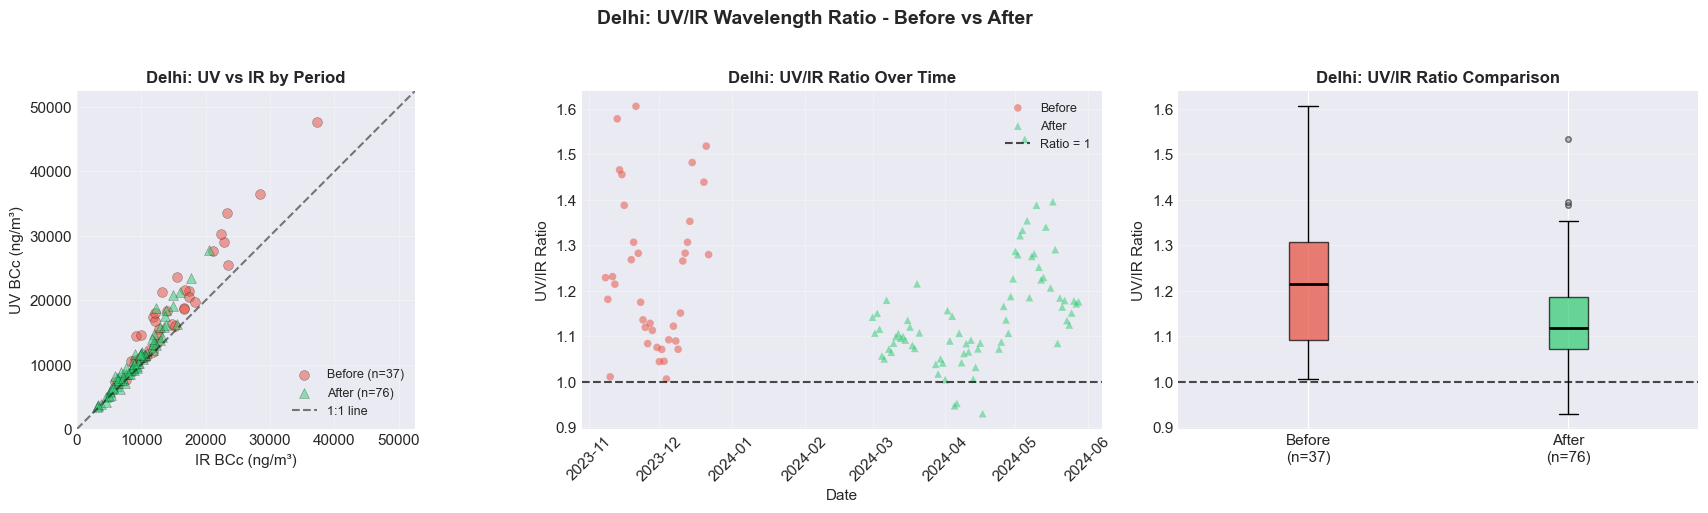


  Period            n   Mean UV/IR   Median UV/IR        Std
  ------------------------------------------------------------
  Before           37        1.234          1.214      0.166
  After            76        1.144          1.118      0.110

JPL: UV/IR Ratio by Flow Period


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_52575/145970430.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


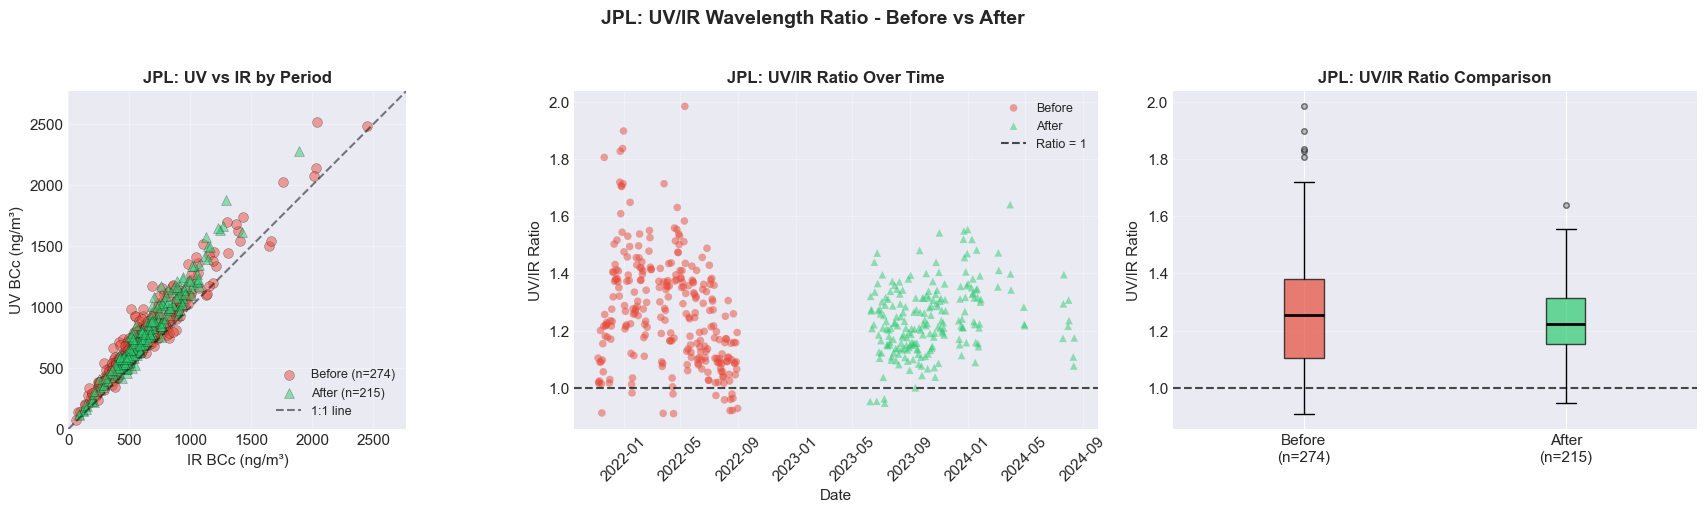


  Period            n   Mean UV/IR   Median UV/IR        Std
  ------------------------------------------------------------
  Before          274        1.265          1.254      0.192
  After           215        1.240          1.224      0.120

SUMMARY: UV/IR Ratio Before vs After

Site         Period            n   Mean UV/IR       Change
------------------------------------------------------------
Beijing      Before           25        1.470           --
             After           197        1.262       -0.207
Delhi        Before           37        1.234           --
             After            76        1.144       -0.090
JPL          Before          274        1.265           --
             After           215        1.240       -0.025


In [56]:
# UV/IR Ratio Comparison: Before vs After
# Higher UV/IR ratio suggests biomass burning, lower ratio suggests fossil fuel

print("\n" + "="*80)
print("UV/IR RATIO COMPARISON: Before vs After")
print("="*80)
print("\nInterpretation:")
print("  - UV/IR > 1.0: Strong UV absorption → biomass burning")
print("  - UV/IR ~ 1.0: Equal absorption → mixed sources")
print("  - UV/IR < 1.0: Strong IR absorption → fossil fuel")
print()

uv_ir_results = {}

for site_name in ['Beijing', 'Delhi', 'JPL']:
    if site_name not in aethalometer_data:
        continue
    
    df_aeth = aethalometer_data[site_name].copy()
    
    # Check if both UV and IR are available
    if 'UV BCc' not in df_aeth.columns or 'IR BCc' not in df_aeth.columns:
        print(f"{site_name}: Missing UV or IR data")
        continue
    
    # Add flow period
    df_aeth['flow_period'] = df_aeth['day_9am'].apply(lambda d: classify_flow_period(d, site_name))
    
    # Get valid UV/IR data
    valid_mask = df_aeth['UV BCc'].notna() & df_aeth['IR BCc'].notna() & (df_aeth['IR BCc'] > 0)
    df_valid = df_aeth[valid_mask].copy()
    df_valid['UV_IR_ratio'] = df_valid['UV BCc'] / df_valid['IR BCc']
    
    print(f"\n{'='*60}")
    print(f"{site_name}: UV/IR Ratio by Flow Period")
    print(f"{'='*60}")
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # ========== 1. UV vs IR Scatter by Period ==========
    ax1 = axes[0]
    
    period_configs = [
        ('before', 'Before', '#E74C3C', 'o'),
        ('after', 'After', '#2ECC71', '^')
    ]
    
    site_results = {}
    
    for period, period_label, color, marker in period_configs:
        period_data = df_valid[df_valid['flow_period'] == period]
        
        if len(period_data) >= 3:
            ax1.scatter(period_data['IR BCc'], period_data['UV BCc'],
                       color=color, marker=marker, alpha=0.5, s=50,
                       label=f'{period_label} (n={len(period_data)})', edgecolors='black', linewidth=0.3)
            
            site_results[period] = {
                'n': len(period_data),
                'mean_ratio': period_data['UV_IR_ratio'].mean(),
                'median_ratio': period_data['UV_IR_ratio'].median(),
                'std_ratio': period_data['UV_IR_ratio'].std()
            }
    
    # Add 1:1 line
    if len(df_valid) > 0:
        max_val = max(df_valid['IR BCc'].max(), df_valid['UV BCc'].max()) * 1.1
        ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        ax1.set_xlim(0, max_val)
        ax1.set_ylim(0, max_val)
        ax1.set_aspect('equal', adjustable='box')
    
    ax1.set_xlabel('IR BCc (ng/m³)', fontsize=11)
    ax1.set_ylabel('UV BCc (ng/m³)', fontsize=11)
    ax1.set_title(f'{site_name}: UV vs IR by Period', fontsize=12, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # ========== 2. UV/IR Ratio Time Series ==========
    ax2 = axes[1]
    
    for period, period_label, color, marker in period_configs:
        period_data = df_valid[df_valid['flow_period'] == period]
        if len(period_data) > 0:
            ax2.scatter(period_data['day_9am'], period_data['UV_IR_ratio'],
                       color=color, marker=marker, alpha=0.5, s=30,
                       label=f'{period_label}', edgecolors='none')
    
    ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=1.5, alpha=0.7, label='Ratio = 1')
    ax2.set_xlabel('Date', fontsize=11)
    ax2.set_ylabel('UV/IR Ratio', fontsize=11)
    ax2.set_title(f'{site_name}: UV/IR Ratio Over Time', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # ========== 3. UV/IR Ratio Boxplot Comparison ==========
    ax3 = axes[2]
    
    boxplot_data = []
    boxplot_labels = []
    boxplot_colors = []
    
    for period, period_label, color, _ in period_configs:
        period_data = df_valid[df_valid['flow_period'] == period]
        if len(period_data) >= 3:
            boxplot_data.append(period_data['UV_IR_ratio'].values)
            boxplot_labels.append(f'{period_label}\n(n={len(period_data)})')
            boxplot_colors.append(color)
    
    if len(boxplot_data) > 0:
        bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,
                        medianprops=dict(color='black', linewidth=2),
                        flierprops=dict(marker='o', markerfacecolor='gray', markersize=4, alpha=0.5))
        
        for patch, color in zip(bp['boxes'], boxplot_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax3.axhline(y=1.0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax3.set_ylabel('UV/IR Ratio', fontsize=11)
    ax3.set_title(f'{site_name}: UV/IR Ratio Comparison', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'{site_name}: UV/IR Wavelength Ratio - Before vs After',
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    uv_ir_results[site_name] = site_results
    
    # Print summary
    print(f"\n  {'Period':<10s} {'n':>8s} {'Mean UV/IR':>12s} {'Median UV/IR':>14s} {'Std':>10s}")
    print("  " + "-" * 60)
    for period, period_label, _, _ in period_configs:
        if period in site_results:
            r = site_results[period]
            print(f"  {period_label:<10s} {r['n']:>8d} {r['mean_ratio']:>12.3f} {r['median_ratio']:>14.3f} {r['std_ratio']:>10.3f}")

# Summary table
print("\n" + "="*80)
print("SUMMARY: UV/IR Ratio Before vs After")
print("="*80)
print(f"\n{'Site':<12s} {'Period':<10s} {'n':>8s} {'Mean UV/IR':>12s} {'Change':>12s}")
print("-" * 60)

for site_name in ['Beijing', 'Delhi', 'JPL']:
    if site_name not in uv_ir_results:
        continue
    results = uv_ir_results[site_name]
    
    before = results.get('before', {})
    after = results.get('after', {})
    
    if before:
        print(f"{site_name:<12s} {'Before':<10s} {before['n']:>8d} {before['mean_ratio']:>12.3f} {'--':>12s}")
    if after:
        change = after['mean_ratio'] - before['mean_ratio'] if before else 0
        change_str = f"{change:+.3f}" if before else "--"
        print(f"{'':<12s} {'After':<10s} {after['n']:>8d} {after['mean_ratio']:>12.3f} {change_str:>12s}")